# Quesiton 1. Problem 8. Numerical comparison

Minimize over $x \in \mathbb{R}^m$:

$$
\min_{x \in \mathbb{R}^m} \|b - A x\|_1 + \lambda \|x\|_2^2,
$$

where $A \in \mathbb{R}^{n \times m}$ with $n \ll m$, $b \in \mathbb{R}^n$, and $\lambda > 0$.

We compare the following approaches:
- solving the primal problem using CVXPY;
- a gradient-based method implemented in PyTorch;
- the projected gradient algorithm for the dual problem;
- the ADMM algorithm derived above.

In [191]:
import numpy as np
import cvxpy as cp
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n, m = 200, 300
np.random.seed(0)
A = np.random.randn(n, m)
b = np.random.randn(n)
lam = 1

## 1. Using CVXPY

In [192]:
def solve_cvxpy():
    x = cp.Variable(m)
    obj = cp.norm1(b - A @ x) + lam * cp.sum_squares(x)
    prob = cp.Problem(cp.Minimize(obj))
    
    start = time.time()
    prob.solve()
    solve_time = time.time() - start

    print(f"CVXPY status: {prob.status}")
    print(f"CVXPY: objective = {cvx_obj:.6f}; time = {cvx_time:.4f}s")
    return prob.value, x.value, solve_time

cvx_obj, x_cvx, cvx_time = solve_cvxpy()

CVXPY status: optimal
CVXPY: objective = 2.020056; time = 0.0758s


## 2. Using gradient-based method

In [193]:
def solve_pytorch(learning_rate, max_iter):
    A_torch = torch.tensor(A.astype(np.float32))
    b_torch = torch.tensor(b.astype(np.float32)) 
    
    def objective(x):
        return torch.norm(b_torch - A_torch @ x, p=1) + lam * torch.norm(x, p=2)**2
    
    x_torch = torch.zeros(m, requires_grad=True, dtype=torch.float32)
    optimizer = optim.Adam([x_torch], lr=learning_rate)
    
    start = time.time()
    obj_history = []
    
    for i in range(max_iter):
        optimizer.zero_grad()
        loss = objective(x_torch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([x_torch], max_norm=1.0)
        optimizer.step()
        obj_history.append(loss.item())
    
    solve_time = time.time() - start
    x_np = x_torch.detach().numpy()
    final_obj = objective(x_torch).item()
    
    return final_obj, x_np, solve_time, obj_history

learning_rates = [1e-4, 5e-4, 1e-3, 1e-2]
best_torch_obj = float('inf')
best_torch_x = None
best_torch_history = None

for lr in learning_rates:
    torch_obj, x_torch, torch_time, torch_history = solve_pytorch(learning_rate=lr, max_iter=2500)
    if torch_obj < best_torch_obj:
        best_torch_obj = torch_obj
        best_torch_x = x_torch
        best_torch_history = torch_history
        best_lr = lr

torch_obj, x_torch, torch_history = best_torch_obj, best_torch_x, best_torch_history
print(f"PyTorch: objective = {torch_obj:.6f}, time = {torch_time:.4f}s (best lr={best_lr})")

PyTorch: objective = 2.318214, time = 0.2502s (best lr=0.0005)


## 3. Using projected gradient algorithm for the dual problem

The dual problem is:
$$
\min_{\|y\|_\infty \leq 1} y^\top b + \frac{1}{4\lambda} y^\top A A^\top y
$$

In [194]:
def solve_dual_pg(step_size=0.01, max_iter=5000):
    n, m = A.shape
    
    def dual_objective(y):
        return np.dot(y, b) + (1/(4*lam)) * np.dot(y, A @ A.T @ y)
    
    def dual_gradient(y):
        return b + (1/(2*lam)) * (A @ (A.T @ y))
    
    def proj_linf(y):
        return np.clip(y, -1, 1)
    
    y = np.zeros(n)
    best_y = y.copy()
    best_dual_obj = float('inf') 
    
    obj_history = []
    start = time.time()
    
    for i in range(max_iter):
        current_dual = dual_objective(y)

        if current_dual < best_dual_obj:
            best_dual_obj = current_dual
            best_y = y.copy()
        
        grad = dual_gradient(y)
        y_new = y - step_size * grad
        
        y_new = proj_linf(y_new)
        
        new_dual = dual_objective(y_new)
        if new_dual < current_dual:
            y = y_new
        else:
            y = y_new
            step_size /= 2
        
        if (i + 1) % 50 == 0:
            x_primal = -(A.T @ best_y) / (2 * lam)
            primal_obj = np.linalg.norm(b - A @ x_primal, 1) + lam * np.linalg.norm(x_primal)**2
            obj_history.append(primal_obj)
    
    solve_time = time.time() - start
    
    x_dual = -(A.T @ best_y) / (2 * lam)
    final_obj = np.linalg.norm(b - A @ x_dual, 1) + lam * np.linalg.norm(x_dual)**2
    
    return final_obj, x_dual, solve_time, obj_history

dual_obj, x_dual, dual_time, dual_history = solve_dual_pg()
print(f"Dual PG: Objective = {dual_obj:.6f}, Time = {dual_time:.4f}s")

Dual PG: Objective = 2.020062, Time = 0.5927s


## 4. Using the ADMM algorithm

In [195]:
def solve_admm(rho=1.0, max_iter=500):
    ATA = A.T @ A
    reg_matrix = ATA + (2*lam/rho) * np.eye(m)
    reg_matrix += 1e-10 * np.eye(m)
    
    inv_mat = np.linalg.inv(reg_matrix)
    
    AT = A.T
    
    def soft_threshold(a, kappa):
        return np.sign(a) * np.maximum(0, np.abs(a) - kappa)
    
    x_admm = np.zeros(m)
    z = np.zeros(n)
    u = np.zeros(n)
    
    obj_history = []
    start = time.time()
    
    for i in range(max_iter):
        x_admm = inv_mat @ AT @ (b - z + u)
        
        Az = b - A @ x_admm + u
        z = soft_threshold(Az, 1/rho)
        
        u = u + b - A @ x_admm - z
        
        if (i + 1) % 50 == 0:
            obj = np.linalg.norm(b - A @ x_admm, 1) + lam * np.linalg.norm(x_admm)**2
            obj_history.append(obj)
    
    solve_time = time.time() - start
    final_obj = np.linalg.norm(b - A @ x_admm, 1) + lam * np.linalg.norm(x_admm)**2
    
    return final_obj, x_admm, solve_time, obj_history

admm_obj, x_admm, admm_time, admm_history = solve_admm()
print(f"ADMM: objective = {admm_obj:.6f}, ime = {admm_time:.4f}s")

ADMM: objective = 2.020056, ime = 0.0560s


## 5. Comparison

In [196]:
methods = ['CVXPY', 'PyTorch', 'Dual PG', 'ADMM']
objectives = [cvx_obj, torch_obj, dual_obj, admm_obj]
times = [cvx_time, torch_time, dual_time, admm_time]
solutions = [x_cvx, x_torch, x_dual, x_admm]

print(f"{'Method':<12} {'Objective':<12} {'Time (s)':<10} {'CVXPY Diff':<12}")
print("-" * 47)

for i, method in enumerate(methods):
    obj_diff = objectives[i] - cvx_obj
    print(f"{method:<12} {objectives[i]:<12.6f} {times[i]:<10.4f} {obj_diff:<12.2e}")

Method       Objective    Time (s)   CVXPY Diff  
-----------------------------------------------
CVXPY        2.020056     0.0742     0.00e+00    
PyTorch      2.318214     0.2502     2.98e-01    
Dual PG      2.020062     0.5927     6.61e-06    
ADMM         2.020056     0.0560     -5.15e-14   


Methods show excellent performance, especially ADMM, where the results match up to six decimal places. The gradient-based method yields inferior results. Probably, due to its high sensitivity to the learning rate and inherent limitations.

As mentioned in the assignment, the gradient-based solver implemented in PyTorch is typically very sensitive to the choice of learning rate. Improper tuning can lead to slow convergence, oscillations, or even divergence.

### Solution quality: cosine similarity 

In [197]:
for i, method in enumerate(methods[1:], 1):
    solution_diff = np.linalg.norm(solutions[i] - x_cvx)
    cosine_sim = np.dot(solutions[i], x_cvx) / (np.linalg.norm(solutions[i]) * np.linalg.norm(x_cvx) + 1e-10)
    print(f"{method}: {cosine_sim:.6f}")

PyTorch: 0.990285
Dual PG: 1.000000
ADMM: 1.000000


## 6. Performance Visualization

### Runtime comparison

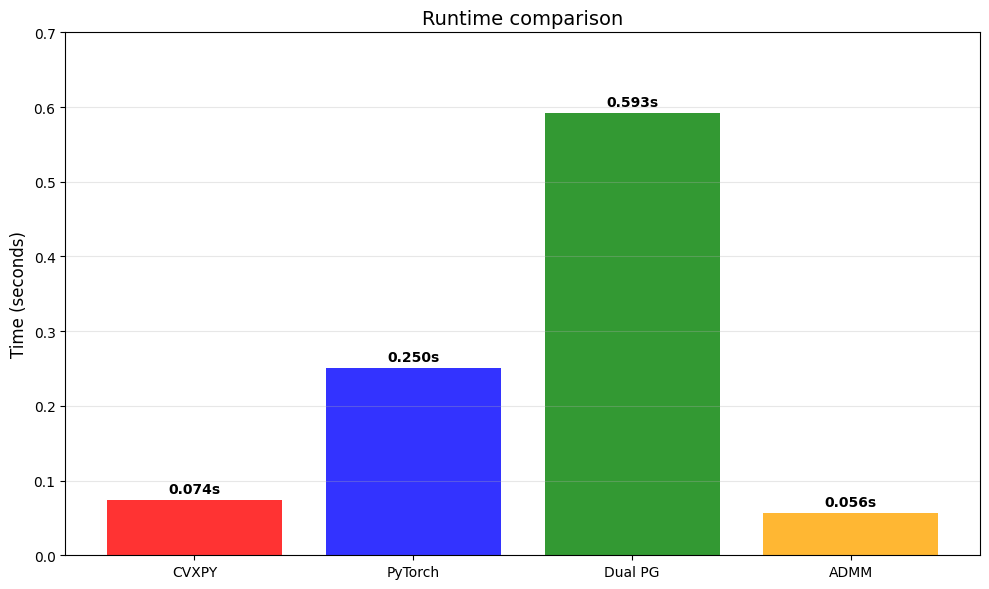

In [198]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, times, color=['red', 'blue', 'green', 'orange'], alpha=0.8)

min_time = min(times)
max_time = max(times)
range_time = max_time - min_time

y_min = max(0, min_time - range_time * 0.2)
y_max = max_time + range_time * 0.2
plt.ylim(y_min, y_max)

plt.title('Runtime comparison', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + range_time * 0.01,
             f'{height:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Objective values comparison

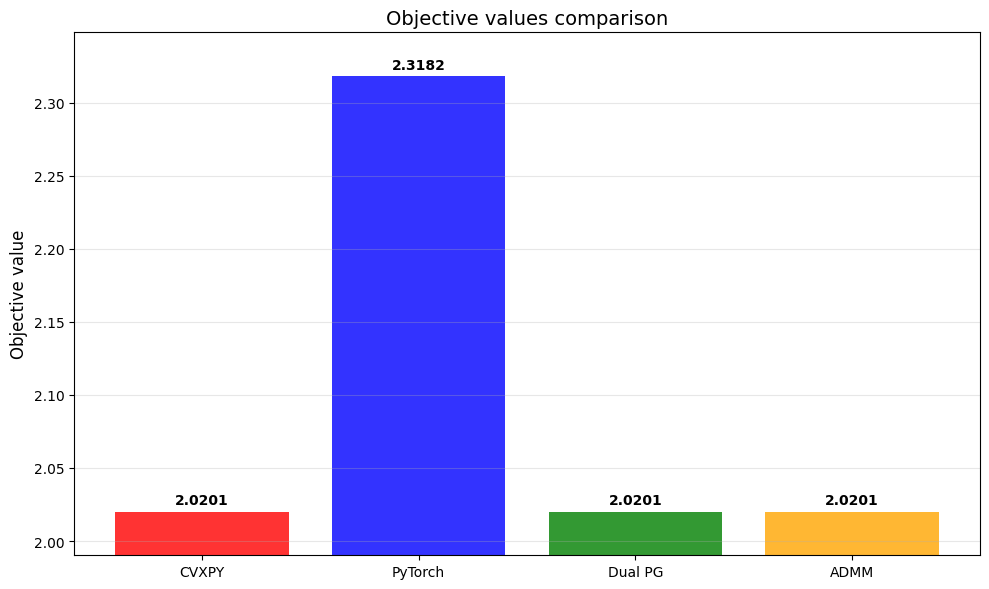

In [199]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, objectives, color=['red', 'blue', 'green', 'orange'], alpha=0.8)

min_obj = min(objectives)
max_obj = max(objectives)
range_obj = max_obj - min_obj

y_min = min_obj - range_obj * 0.1
y_max = max_obj + range_obj * 0.1
plt.ylim(y_min, y_max)

plt.title('Objective values comparison', fontsize=14)
plt.ylabel('Objective value', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + range_obj * 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Convergence comparison

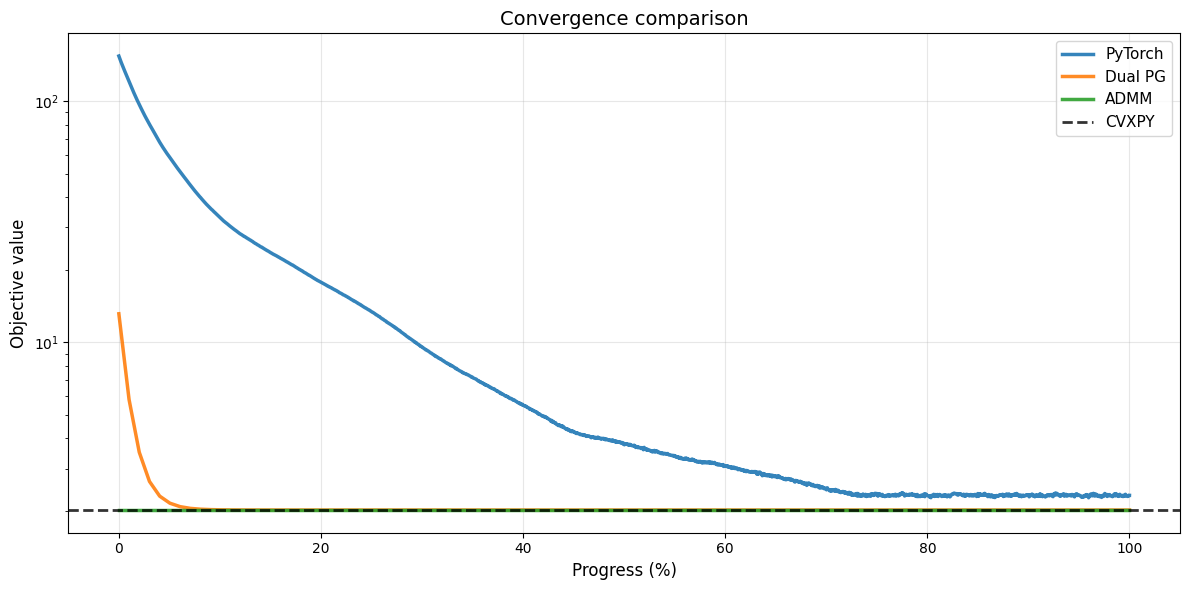

In [200]:
plt.figure(figsize=(12, 6))

torch_x = np.linspace(0, 100, len(torch_history))
plt.plot(torch_x, torch_history, label='PyTorch', linewidth=2.5, alpha=0.9)

dual_x = np.linspace(0, 100, len(dual_history))
plt.plot(dual_x, dual_history, label='Dual PG', linewidth=2.5, alpha=0.9)

admm_x = np.linspace(0, 100, len(admm_history))
plt.plot(admm_x, admm_history, label='ADMM', linewidth=2.5, alpha=0.9)

plt.axhline(y=cvx_obj, color='black', linestyle='--', label='CVXPY', linewidth=2, alpha=0.8)

plt.title('Convergence comparison', fontsize=14)
plt.xlabel('Progress (%)', fontsize=12)
plt.ylabel('Objective value', fontsize=12)
plt.legend(fontsize=11)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ADMM converges from the very beginning because it uses exact minimization for each subproblem.  
The gradient-based method implemented in PyTorch converges slowly and likely not to the exact value, probably because it relies on first-order methods applied to a non-smooth objective.  
In contrast, the projected gradient algorithm for the dual problem converges sufficiently fast and reaches a good value. This is because the dual problem is smooth and strongly convex, and the projection is performed onto a simple constraint set.

## 7. Conclusion

CVXPY demonstrates excellent results and can be effectively used when the solver is working properly.  
ADMM also delivers great results but is slightly slower, which can be considered as a variance. The dual projected gradient method shows good results but requires a lot of time. Gradient-based methods are slow and inaccurate, making them unsuitable for this problem.

# Question 4  

Let $Y \in \mathbb{R}^{p \times q}$ denote a data matrix of observed outputs and $X \in \mathbb{R}^{r \times s}$ an input/data matrix.

## Problem 1

Consider the optimization problem:

$
\min_X \frac{1}{2} \|Y - X\|_F^2 + \lambda \|X\|_*.
$

Derive (or state) the proximal operator of the nuclear norm and show that the optimal solution is obtained by singular-value soft-thresholding.

## Problem 2

Let $Y \in \mathbb{R}^{p \times m}$ and $Z \in \mathbb{R}^{n \times m}$. Consider the optimization problem:

$
\min_W \frac{1}{2} \|Y - WZ\|_F^2 + \lambda \|W\|_*,
$

and rewrite using $U = W$.

(a) Write the augmented Lagrangian and ADMM updates.

(b) Derive the explicit $W$-update (least squares) and the $U$-update (singular-value soft-thresholding).

## Bonus 

Implement the ADMM algorithm and provide an illustration.

In [201]:
def nuclear_norm_admm(Y, Z, lambda_, rho=1.0, max_iter=1000, tol=1e-6):
    def nuclear_norm_prox(X, threshold):
        U, s, Vt = np.linalg.svd(X, full_matrices=False)
        soft_thresh = np.maximum(s - threshold, 0)
        X_prox = U @ np.diag(soft_thresh) @ Vt
        return X_prox, s, soft_thresh

    p, m = Y.shape
    n, m_z = Z.shape
    
    W = np.zeros((p, n))
    U = np.zeros((p, n))
    Lambda = np.zeros((p, n))
    
    ZZT = Z @ Z.T
    ZY = Y @ Z.T
    
    I = np.eye(n)
    
    objectives = []
    primal_residuals = []
    dual_residuals = []
    rank_history = []
    
    for i in range(max_iter):
        # W update
        right_side = ZY + rho * (U - Lambda/rho)
        W = np.linalg.solve(ZZT + rho * I, right_side.T).T
        
        # U update with soft-thresholding
        U_new, s, s_thresh = nuclear_norm_prox(W + Lambda/rho, lambda_/rho)
        
        Lambda = Lambda + rho * (W - U_new)
        U = U_new
        
        data_fit = 0.5 * np.linalg.norm(Y - W @ Z, 'fro')**2
        nuclear_term = lambda_ * np.sum(s_thresh)
        objective = data_fit + nuclear_term
        objectives.append(objective)
        
        primal_residual = np.linalg.norm(W - U, 'fro')
        dual_residual = rho * np.linalg.norm(U - U_new, 'fro')
        
        primal_residuals.append(primal_residual)
        dual_residuals.append(dual_residual)
        rank_history.append(np.sum(s_thresh > 0))
        
        if primal_residual < tol and dual_residual < tol:
            break
    
    results = {
        'W': W,
        'U': U,
        'Lambda': Lambda,
        'objectives': objectives,
        'primal_residuals': primal_residuals,
        'dual_residuals': dual_residuals,
        'rank_history': rank_history,
        'iterations': i + 1
    }
    
    return results

Running ADMM with lambda = 0.1


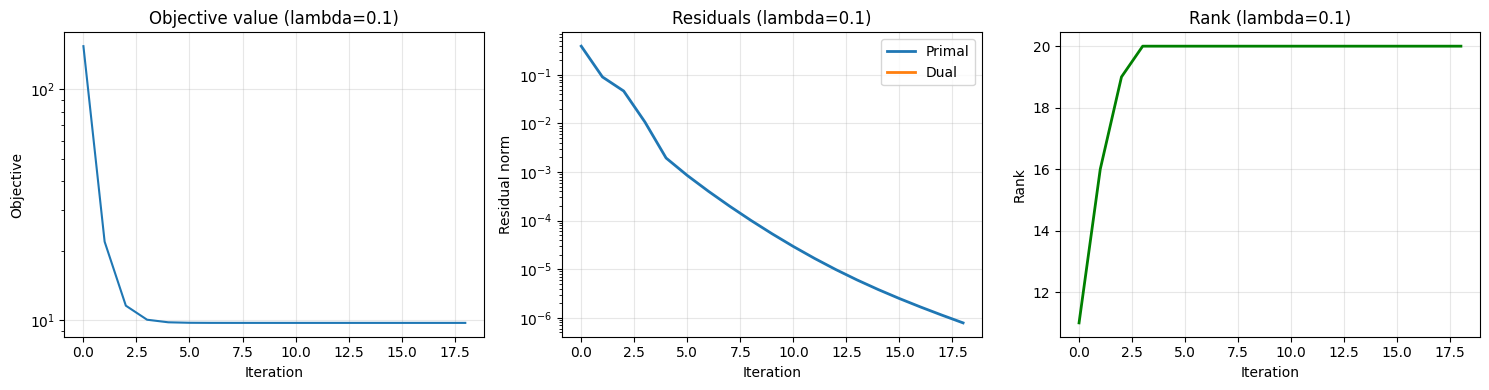

λ=0.1: True rank=3, Estimated rank=20, Relative error=0.0173
Running ADMM with lambda = 0.5


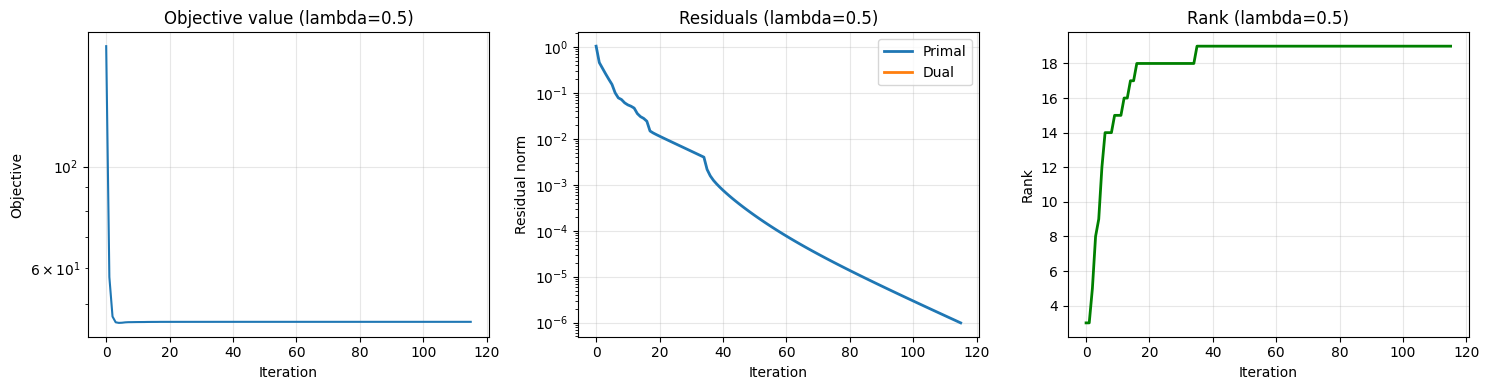

λ=0.5: True rank=3, Estimated rank=20, Relative error=0.0133
Running ADMM with lambda = 1.0


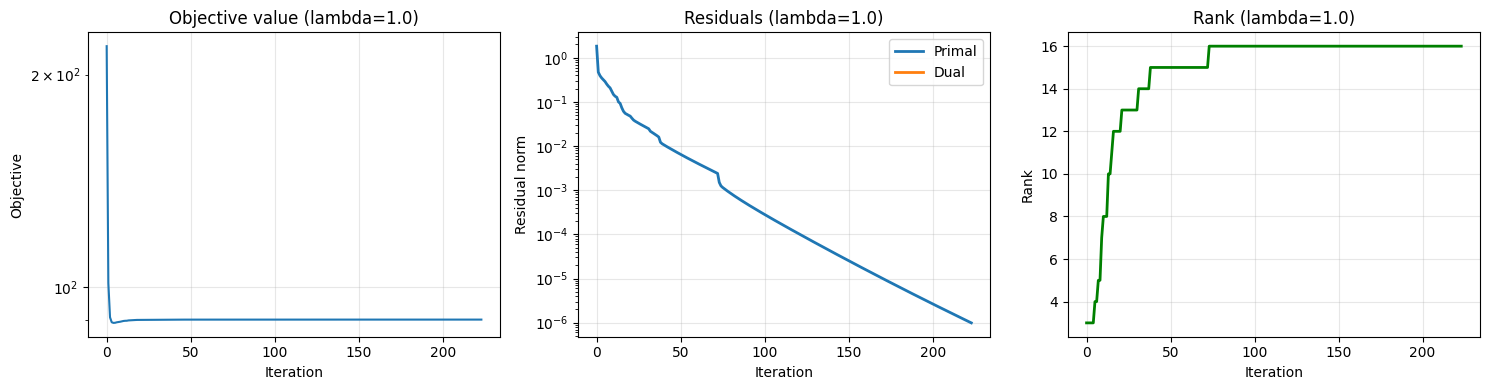

λ=1.0: True rank=3, Estimated rank=20, Relative error=0.0153


In [202]:
def generate_test_data(p=50, n=30, m=40, rank=5, noise_level=0.1):
    W_true = np.random.randn(p, rank) @ np.random.randn(rank, n)
    
    Z = np.random.randn(n, m)
    
    Y = W_true @ Z + noise_level * np.random.randn(p, m)
    
    return Y, Z, W_true

def illustrate_performance():
    Y, Z, W_true = generate_test_data(p=30, n=20, m=25, rank=3)

    lambda_values = [0.1, 0.5, 1.0]
    
    for i, lambda_val in enumerate(lambda_values):
        print(f"Running ADMM with lambda = {lambda_val}")
        results = nuclear_norm_admm(Y, Z, lambda_val, rho=1.0, max_iter=500)
        
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 3, 1)
        plt.plot(results['objectives'])
        plt.title(f'Objective value (lambda={lambda_val})')
        plt.xlabel('Iteration')
        plt.ylabel('Objective')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(results['primal_residuals'], label='Primal', linewidth=2)
        plt.plot(results['dual_residuals'], label='Dual', linewidth=2)
        plt.title(f'Residuals (lambda={lambda_val})')
        plt.xlabel('Iteration')
        plt.ylabel('Residual norm')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        plt.plot(results['rank_history'], color='green', linewidth=2)
        plt.title(f'Rank (lambda={lambda_val})')
        plt.xlabel('Iteration')
        plt.ylabel('Rank')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        W_est = results['W']
        true_rank = np.linalg.matrix_rank(W_true)
        est_rank = np.linalg.matrix_rank(W_est)
        error = np.linalg.norm(W_true - W_est, 'fro') / np.linalg.norm(W_true, 'fro')
        print(f"λ={lambda_val}: True rank={true_rank}, Estimated rank={est_rank}, Relative error={error:.4f}")

illustrate_performance()

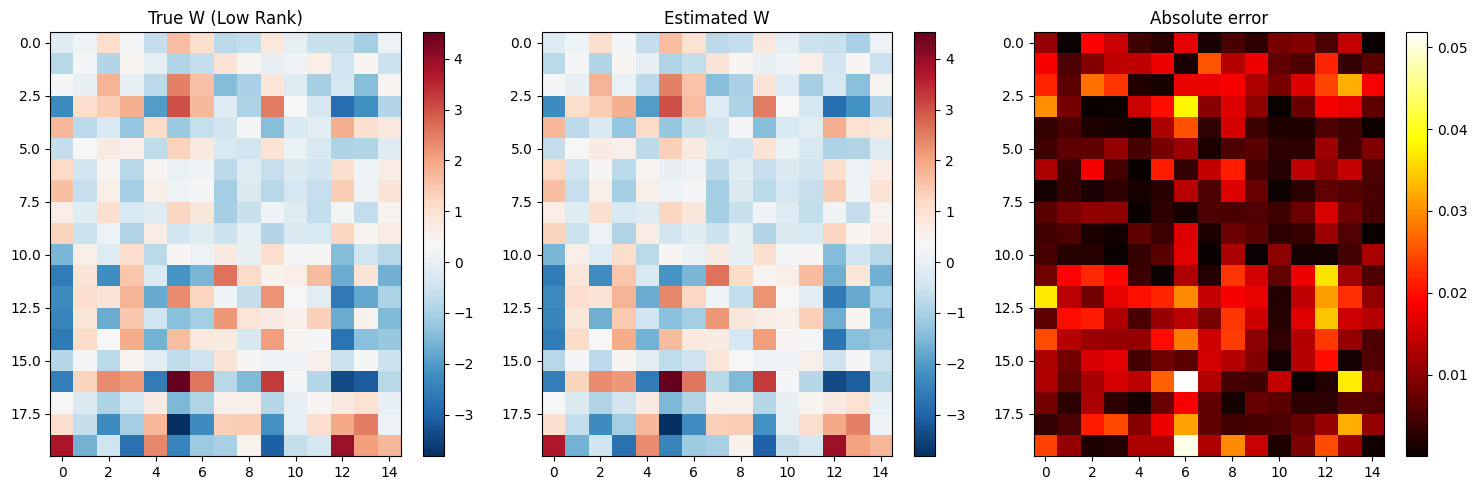

True rank: 2
Estimated rank: 15
Relative error: 0.0107
Final objective: 15.714710


In [203]:

def compare_with_truth():
    Y, Z, W_true = generate_test_data(p=20, n=15, m=20, rank=2, noise_level=0.05)
    
    results = nuclear_norm_admm(Y, Z, lambda_=0.5, rho=1.0, max_iter=1000)
    W_est = results['W']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    vmin = min(W_true.min(), W_est.min())
    vmax = max(W_true.max(), W_est.max())
    
    im1 = axes[0].imshow(W_true, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
    axes[0].set_title('True W (Low Rank)')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(W_est, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
    axes[1].set_title('Estimated W')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(np.abs(W_true - W_est), cmap='hot', aspect='auto')
    axes[2].set_title('Absolute error')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    true_rank = np.linalg.matrix_rank(W_true)
    est_rank = np.linalg.matrix_rank(W_est)
    error = np.linalg.norm(W_true - W_est, 'fro') / np.linalg.norm(W_true, 'fro')
    
    print(f"True rank: {true_rank}")
    print(f"Estimated rank: {est_rank}")
    print(f"Relative error: {error:.4f}")
    print(f"Final objective: {results['objectives'][-1]:.6f}")

compare_with_truth()

# Conclusion

ADMM effectively solves nuclear norm regularized problem by decomposing them into subproblems.  
The explicit W update handles the quadratic data fitting term, while the U update applies soft-thresholding to provide low-rank solution.